## Things to try:
* Look at other notebooks for data preprocessing
* Look at other notebooks for data visualization
* Bet against odds ... %

## Scrape Betting data and simulate if bet according to startegy will win money

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# loading CSV files downloaded from Kaggle
path = "data/"
df = pd.read_csv(path + "spreadspoke_scores.csv")
teams = pd.read_csv(path + "nfl_teams.csv")
teams_clean = pd.read_csv(path + "nfl_teams_clean.csv")
games_elo = pd.read_csv(path + "nfl_elo.csv")

# Loading and Cleaning Data

In [4]:
# replacing blank strings with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# removing rows from specific columns that have null values, resetting index and changing data types
df = df[(df.score_home.isnull() == False) & (df.team_favorite_id.isnull() == False) & (df.over_under_line.isnull() == False) &
        (df.schedule_season >= 1979)]

df.reset_index(drop=True, inplace=True)
df['over_under_line'] = df.over_under_line.astype(float)

# mapping team_id to the correct teams
df['team_home'] = df.team_home.map(teams.set_index('team_name')['team_id'].to_dict())
df['team_away'] = df.team_away.map(teams.set_index('team_name')['team_id'].to_dict())

# fix team_favorite_id for Colts in 1969 and 1971 SB
df.loc[(df.schedule_season == 1968) & (df.schedule_week == 'Superbowl'), 'team_favorite_id'] = 'IND'
df.loc[(df.schedule_season == 1970) & (df.schedule_week == 'Superbowl'), 'team_favorite_id'] = 'IND'

# creating home favorite and away favorite columns (fill na with 0's)
df.loc[df.team_favorite_id == df.team_home, 'home_favorite'] = 1
df.loc[df.team_favorite_id == df.team_away, 'away_favorite'] = 1
df.home_favorite.fillna(0, inplace=True)
df.away_favorite.fillna(0, inplace=True)

# creating over / under column (fill na with 0's)
df.loc[((df.score_home + df.score_away) > df.over_under_line), 'over'] = 1
df.over.fillna(0, inplace=True)

# stadium neutral and schedule playoff as boolean
df['stadium_neutral'] = df.stadium_neutral.astype(int)
df['schedule_playoff'] = df.schedule_playoff.astype(int)

# change data type of date columns
df['schedule_date'] = pd.to_datetime(df['schedule_date'])
games_elo['date'] = pd.to_datetime(games_elo['date'])

In [5]:
# fixing some schedule_week column errors and converting column to integer data type
df.loc[(df.schedule_week == '18'), 'schedule_week'] = '17'
df.loc[(df.schedule_week == 'Wildcard') | (df.schedule_week == 'WildCard'), 'schedule_week'] = '18'
df.loc[(df.schedule_week == 'Division'), 'schedule_week'] = '19'
df.loc[(df.schedule_week == 'Conference'), 'schedule_week'] = '20'
df.loc[(df.schedule_week == 'Superbowl') | (df.schedule_week == 'SuperBowl'), 'schedule_week'] = '21'
df['schedule_week'] = df.schedule_week.astype(int)

In [6]:
# Cleaning games_elo and df to merge correctly
wsh_map = {'WSH' : 'WAS'}
games_elo.loc[games_elo.team1 == 'WSH', 'team1'] = 'WAS' 
games_elo.loc[games_elo.team2 == 'WSH', 'team2'] = 'WAS'

# fix dates
df.loc[(df.schedule_date == '2016-09-19') & (df.team_home == 'MIN'), 'schedule_date'] = datetime.datetime(2016, 9, 18)
df.loc[(df.schedule_date == '2017-01-22') & (df.schedule_week == 21), 'schedule_date'] = datetime.datetime(2017, 2, 5)
df.loc[(df.schedule_date == '1990-01-27') & (df.schedule_week == 21), 'schedule_date'] = datetime.datetime(1990, 1, 28)
df.loc[(df.schedule_date == '1990-01-13'), 'schedule_date'] = datetime.datetime(1990, 1, 14)
games_elo.loc[(games_elo.date == '2016-01-09'), 'date'] = datetime.datetime(2016, 1, 10)
games_elo.loc[(games_elo.date == '2016-01-08'), 'date'] = datetime.datetime(2016, 1, 9)
games_elo.loc[(games_elo.date == '2016-01-16'), 'date'] = datetime.datetime(2016, 1, 17)
games_elo.loc[(games_elo.date == '2016-01-15'), 'date'] = datetime.datetime(2016, 1, 16)

In [7]:
# Drop season before 2000
df = df.drop(df[df.schedule_season < 2000].index)

# Feature Engineering
- Current W-L %
- Last season W-L % (need to manually insert for 2001 season or include 2000 season and discard)

**Need current W-L for home and away!**

In [8]:
for team in teams.team_id.unique().tolist():
    for season in range(2000,2019): 
        
        wins, games_played = 0., 0.
        
        for week in range(1,18):
            current_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == week)]
            
            # If a game exists
            if(current_game.shape[0] == 1):
                current_game = current_game.iloc[0]
                
    
                if ((current_game.team_home == team) & (current_game.score_home > current_game.score_away)):
                    wins += 1
                    
                elif ((current_game.team_away == team) & (current_game.score_away > current_game.score_home)):
                    wins += 1
                
                # If not a tie count game as part of record
                if(current_game.score_away != current_game.score_home):
                    games_played += 1
                
                 # If week one put default record as 0
                if(week == 1):
                    if(current_game.team_home == team):
                        df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == week), 'team_home_current_win_pct'] = 0 
                    else:
                        df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == week), 'team_away_current_win_pct'] = 0 

            # Put record for next week game + account for bye week
            next_week_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == week+1)]
            # If a game exists
            if(next_week_game.shape[0] == 1):
                next_week_game = next_week_game.iloc[0]
                if(next_week_game.team_home == team):
                    df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == week+1), 'team_home_current_win_pct'] = 0 if games_played == 0 else wins/games_played
                else:
                    df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == week+1), 'team_away_current_win_pct'] = 0 if games_played == 0 else wins/games_played
            else: # Bye week
                next_twoweek_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == week+2)]
                # If a game exists
                if(next_twoweek_game.shape[0] == 1):
                    next_twoweek_game = next_twoweek_game.iloc[0]
                    if(next_twoweek_game.team_home == team):
                        df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == week+2), 'team_home_current_win_pct'] = 0 if games_played == 0 else wins/games_played
                    else:
                        df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == week+2), 'team_away_current_win_pct'] = 0 if games_played == 0 else wins/games_played

                    
        # if beyond week 17 (playoffs use season record)
        for postseason_week in range(18,22):
            current_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == season) & (df.schedule_week == postseason_week)]
            # If a game exists
            if(current_game.shape[0] == 1):
                current_game = current_game.iloc[0]
                if(current_game.team_home == team):
                    df.loc[(df.team_home == team) & (df.schedule_season == season) & (df.schedule_week == postseason_week), 'team_home_current_win_pct'] = 0 if games_played == 0 else wins/games_played
                else:
                    df.loc[(df.team_away == team) & (df.schedule_season == season) & (df.schedule_week == postseason_week), 'team_away_current_win_pct'] = 0 if games_played == 0 else wins/games_played
           
        # if week 17 put current in next season
        # if last season is 2000 (no record) put in as 
        next_season = season+1
        for week in range(1,22):
            next_season_game = df[((df.team_home == team) | (df.team_away == team)) & (df.schedule_season == next_season) & (df.schedule_week == week)]
            if(next_season_game.shape[0] == 1):
                next_season_game = next_season_game.iloc[0]
                if(next_season_game.team_home == team):
                    df.loc[(df.team_home == team) & (df.schedule_season == next_season) & (df.schedule_week == week), 'team_home_lastseason_win_pct'] = 0 if games_played == 0 else wins/games_played
                elif(next_season_game.team_away == team):
                    df.loc[(df.team_away == team) & (df.schedule_season == next_season) & (df.schedule_week == week), 'team_away_lastseason_win_pct'] = 0 if games_played == 0 else wins/games_played


In [9]:
# Drop season before 2001
df = df.drop(df[df.schedule_season < 2001].index)

In [19]:
df[((df.team_home == "OAK") | (df.team_away == "OAK")) & (df.schedule_season == 2009)]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,weather_wind_mph,weather_humidity,weather_detail,home_favorite,away_favorite,over,team_away_current_win_pct,team_home_current_win_pct,team_home_lastseason_win_pct,team_away_lastseason_win_pct
7193,2009-09-14,2009,1,0,OAK,20.0,24.0,LAC,LAC,-10.0,...,12.0,81,NaN,0.0,1.0,1.0,0.000000,0.000000,0.3125,0.500000
7202,2009-09-20,2009,2,0,KC,10.0,13.0,OAK,KC,-1.5,...,7.0,64,NaN,1.0,0.0,0.0,0.000000,0.000000,0.1250,0.312500
7219,2009-09-27,2009,3,0,OAK,3.0,23.0,DEN,DEN,-2.5,...,6.0,61,NaN,0.0,1.0,0.0,1.000000,0.500000,0.3125,0.500000
7229,2009-10-04,2009,4,0,HOU,29.0,6.0,OAK,HOU,-8.0,...,0.0,NaN,DOME,1.0,0.0,0.0,0.333333,0.333333,0.5000,0.312500
7247,2009-10-11,2009,5,0,NYG,44.0,7.0,OAK,NYG,-15.0,...,11.0,47,NaN,1.0,0.0,1.0,0.250000,1.000000,0.7500,0.312500
7262,2009-10-18,2009,6,0,OAK,13.0,9.0,PHI,PHI,-14.0,...,9.0,84,NaN,0.0,1.0,0.0,0.750000,0.200000,0.3125,0.600000
7276,2009-10-25,2009,7,0,OAK,0.0,38.0,NYJ,NYJ,-6.0,...,6.0,76,NaN,0.0,1.0,1.0,0.500000,0.333333,0.3125,0.562500
7291,2009-11-01,2009,8,0,LAC,24.0,16.0,OAK,LAC,-16.5,...,4.0,53,NaN,1.0,0.0,0.0,0.285714,0.500000,0.5000,0.312500
7315,2009-11-15,2009,10,0,OAK,10.0,16.0,KC,OAK,-2.5,...,5.0,70,NaN,1.0,0.0,0.0,0.125000,0.250000,0.3125,0.125000
7334,2009-11-22,2009,11,0,OAK,20.0,17.0,CIN,CIN,-8.5,...,8.0,76,NaN,0.0,1.0,1.0,0.777778,0.222222,0.3125,0.266667


In [11]:
# Check for rows/cols with null value
null_columns=df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head())

      weather_temperature  weather_wind_mph weather_humidity weather_detail
5050                 72.0               6.0               79            NaN
5051                 80.0              12.0               58            NaN
5052                 75.0              11.0               84            NaN
5053                 79.0              14.0               68            NaN
5054                 75.0              13.0               78            NaN


## Combine data into one dataframe
**Note: use merge to join dataframe**
1. df - add team_id for home and away (data from teams)
2. df - add ELO prob for home and away 

In [20]:
# Get division info. in each team to create 'division_game' flag
df = pd.merge(df, teams_clean[["team_id", "team_division"]], how='inner', left_on=['team_home'], right_on=['team_id'])
df = pd.merge(df, teams_clean[["team_id", "team_division"]], how='inner', left_on=['team_away'], right_on=['team_id'])
df = df.rename(columns={'team_division_x': 'team_home_division', 'team_division_y': 'team_away_division'})

# # drop unused columns
df = df.drop(['team_id_x', 'team_id_y'], axis=1)

df["division_game"] = df["team_home_division"] == df["team_away_division"]

### Merge elo data

In [21]:
df = df.merge(games_elo[['date', 'team1', 'team2', 'elo_prob1', 'elo_prob2']], 
                      left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')

# merge to fix neutral games where team_home and team_away are switched
games_elo2 = games_elo.rename(columns={'team1' : 'team2', 
                                       'team2' : 'team1', 
                                       'elo1' : 'elo2', 
                                       'elo2' : 'elo1',
                                       'elo_prob1' : 'elo_prob2', 
                                       'elo_prob2' : 'elo_prob1'})

df = df.merge(games_elo2[['date', 'team1', 'team2', 'elo_prob1', 'elo_prob2']], 
                      left_on=['schedule_date', 'team_home', 'team_away'], right_on=['date', 'team1', 'team2'], how='left')

In [22]:
df.columns.values

array(['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'home_favorite', 'away_favorite', 'over',
       'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct',
       'team_home_division', 'team_away_division', 'division_game',
       'date_x', 'team1_x', 'team2_x', 'elo_prob1_x', 'elo_prob2_x',
       'date_y', 'team1_y', 'team2_y', 'elo_prob1_y', 'elo_prob2_y'], dtype=object)

In [23]:
# separating merged columns into x and y cols
x_cols = ['date_x', 'team1_x', 'team2_x', 'elo_prob1_x', 'elo_prob2_x']
y_cols = ['date_y', 'team1_y', 'team2_y', 'elo_prob1_y','elo_prob2_y']

# filling null values for games_elo merged cols
for x, y in zip(x_cols, y_cols):
    df[x] = df[x].fillna(df[y]) 

# removing y_cols from dataframe    
# df = df[['schedule_date', 'schedule_season', 'schedule_week',
#        'schedule_playoff', 'team_home', 'score_home', 'score_away',
#        'team_away', 'team_favorite_id', 'spread_favorite',
#        'over_under_line', 'stadium', 'stadium_neutral',
#        'weather_temperature', 'weather_wind_mph', 'weather_humidity',
#        'weather_detail', 'team_home_division', 'team_away_division',
#        'division_game', 'date_x', 'team1_x', 'team2_x', 'elo_prob1_x',
#        'elo_prob2_x', 'team_away_current_win_pct', 'team_home_current_win_pct',
#        'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct']]
df = df[['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'home_favorite', 'away_favorite', 'over',
       'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct',
       'team_home_division', 'team_away_division', 'division_game',
        'elo_prob1_x', 'elo_prob2_x']]

# remove _x ending from column names
df.columns = df.columns.str.replace('_x', '')

In [24]:
# Check for rows/cols with null value
null_columns=df.columns[df.isnull().any()]
print(df[df.isnull().any(axis=1)][null_columns].head())

   weather_temperature  weather_wind_mph weather_humidity weather_detail  \
0                 72.0               6.0               79            NaN   
1                 30.0              12.0               68            NaN   
2                 73.0              10.0              NaN            NaN   
3                 57.0               9.0               76            NaN   
4                 72.0               0.0              NaN           DOME   

   elo_prob1  elo_prob2  
0   0.847023   0.152977  
1   0.781479   0.218521  
2   0.751455   0.248545  
3   0.401823   0.598177  
4   0.421488   0.578512  


In [25]:
df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,over,team_away_current_win_pct,team_home_current_win_pct,team_home_lastseason_win_pct,team_away_lastseason_win_pct,team_home_division,team_away_division,division_game,elo_prob1,elo_prob2
0,2001-09-09,2001,1,0,BAL,17.0,6.0,CHI,BAL,-10.5,...,0.0,0.000000,0.000000,0.7500,0.3125,AFC North,NFC North,False,0.847023,0.152977
1,2009-12-20,2009,15,0,BAL,31.0,7.0,CHI,BAL,-11.0,...,0.0,0.384615,0.538462,0.6875,0.5625,AFC North,NFC North,False,0.781479,0.218521
2,2017-10-15,2017,6,0,BAL,24.0,27.0,CHI,BAL,-6.5,...,1.0,0.200000,0.600000,0.5000,0.1875,AFC North,NFC North,False,0.751455,0.248545
3,2002-09-29,2002,4,0,BUF,33.0,27.0,CHI,BUF,-3.0,...,1.0,0.666667,0.333333,0.1875,0.8125,AFC East,NFC North,False,0.401823,0.598177
4,2010-11-07,2010,9,0,BUF,19.0,22.0,CHI,CHI,-3.0,...,0.0,0.571429,0.000000,0.3750,0.4375,AFC East,NFC North,False,0.421488,0.578512


In [26]:
df.elo_prob1.describe()

count    4783.000000
mean        0.582349
std         0.168648
min         0.092782
25%         0.465489
50%         0.591249
75%         0.709157
max         0.964578
Name: elo_prob1, dtype: float64

In [27]:
# Drop column where there are eno Elo information
df = df.dropna(subset=['elo_prob1', 'elo_prob2'])

In [28]:
# creating result column df.loc[(df.score_home > df.score_away), 'result'
df['result'] = (df.score_home > df.score_away).astype(int)

In [29]:
df.shape

(4783, 30)

In [30]:
# creating home favorite and away favorite columns (fill na with 0's)
df.loc[df.team_favorite_id == df.team_home, 'home_favorite'] = 1
df.loc[df.team_favorite_id == df.team_away, 'away_favorite'] = 1
df.home_favorite.fillna(0, inplace=True)
df.away_favorite.fillna(0, inplace=True)

In [31]:
# Change boolean column to 0/1
df.division_game = df.division_game.astype(int)
df.home_favorite = df.home_favorite.astype(int)
df.away_favorite = df.away_favorite.astype(int)

# Export preprocessed data to CSV

In [33]:
df.to_csv(path+"data_preprocessed.csv")

## Exploratory Data Analysis

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4783 entries, 0 to 4786
Data columns (total 30 columns):
schedule_date                   4783 non-null datetime64[ns]
schedule_season                 4783 non-null int64
schedule_week                   4783 non-null int64
schedule_playoff                4783 non-null int64
team_home                       4783 non-null object
score_home                      4783 non-null float64
score_away                      4783 non-null float64
team_away                       4783 non-null object
team_favorite_id                4783 non-null object
spread_favorite                 4783 non-null float64
over_under_line                 4783 non-null float64
stadium                         4783 non-null object
stadium_neutral                 4783 non-null int64
weather_temperature             4672 non-null float64
weather_wind_mph                4672 non-null float64
weather_humidity                2431 non-null object
weather_detail                  134

In [84]:
df.columns.values

array(['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'home_favorite', 'away_favorite', 'over',
       'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct',
       'team_home_division', 'team_away_division', 'division_game',
       'elo_prob1', 'elo_prob2', 'result'], dtype=object)

In [86]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
schedule_season,4783.0,2009.490069,5.171005,2001.000000,2005.000000,2009.000000,2014.000000,2018.000000
schedule_week,4783.0,9.486933,5.254918,1.000000,5.000000,10.000000,14.000000,21.000000
schedule_playoff,4783.0,0.038261,0.191845,0.000000,0.000000,0.000000,0.000000,1.000000
score_home,4783.0,23.237090,10.367254,0.000000,16.000000,23.000000,30.000000,62.000000
score_away,4783.0,20.686180,10.045255,0.000000,13.000000,20.000000,27.000000,59.000000
spread_favorite,4783.0,-5.374242,3.387991,-26.500000,-7.000000,-4.500000,-3.000000,0.000000
over_under_line,4783.0,43.237194,4.908705,30.000000,40.000000,43.500000,46.500000,63.500000
stadium_neutral,4783.0,0.011499,0.106626,0.000000,0.000000,0.000000,0.000000,1.000000
weather_temperature,4672.0,60.571918,15.593036,-6.000000,50.000000,65.000000,72.000000,97.000000
weather_wind_mph,4672.0,6.284889,5.440553,0.000000,0.000000,6.000000,10.000000,40.000000


In [87]:
# null values by column
df.isnull().sum(axis=0)

schedule_date                      0
schedule_season                    0
schedule_week                      0
schedule_playoff                   0
team_home                          0
score_home                         0
score_away                         0
team_away                          0
team_favorite_id                   0
spread_favorite                    0
over_under_line                    0
stadium                            0
stadium_neutral                    0
weather_temperature              111
weather_wind_mph                 111
weather_humidity                2352
weather_detail                  3441
home_favorite                      0
away_favorite                      0
over                               0
team_away_current_win_pct          0
team_home_current_win_pct          0
team_home_lastseason_win_pct       0
team_away_lastseason_win_pct       0
team_home_division                 0
team_away_division                 0
division_game                      0
e

In [88]:
# some percentages to take into consideration when betting
# home_win = "{:.2f}".format((sum((df.result == 1) & (df.stadium_neutral == 0)) / len(df)) * 100)
home_win = "{:.2f}".format((sum((df.result == 1) & (df.stadium_neutral == 0)) / sum(df.stadium_neutral == 0)) * 100)
# away_win = "{:.2f}".format((sum((df.result == 0) & (df.stadium_neutral == 0)) / len(df)) * 100)
away_win = "{:.2f}".format((sum((df.result == 0) & (df.stadium_neutral == 0)) / sum(df.stadium_neutral == 0)) * 100)

under_line = "{:.2f}".format((sum((df.score_home + df.score_away) < df.over_under_line) / len(df)) * 100)
over_line = "{:.2f}".format((sum((df.score_home + df.score_away) > df.over_under_line) / len(df)) * 100)
equal_line = "{:.2f}".format((sum((df.score_home + df.score_away) == df.over_under_line) / len(df)) * 100)

favored = "{:.2f}".format((sum(((df.home_favorite == 1) & (df.result == 1)) | ((df.away_favorite == 1) & (df.result == 0)))
                           / len(df)) * 100)


cover = "{:.2f}".format((sum(((df.home_favorite == 1) & ((df.score_away - df.score_home) < df.spread_favorite)) | 
                             ((df.away_favorite == 1) & ((df.score_home - df.score_away) < df.spread_favorite))) # use score_home - score_away because the fav are swap
                         / len(df)) * 100)

ats = "{:.2f}".format((sum(((df.home_favorite == 1) & ((df.score_away - df.score_home) > df.spread_favorite)) | 
                           ((df.away_favorite == 1) & ((df.score_home - df.score_away) > df.spread_favorite))) 
                       / len(df)) * 100)

In [89]:
# print all percentages
print("Number of Games: " + str(len(df)))
print("Home Straight Up Win Percentage: " + home_win + "%")
print("Away Straight Up Win Percentage: " + away_win + "%")
print("Under Percentage: " + under_line + "%")
print("Over Percentage: " + over_line + "%")
print("Equal Percentage: " + equal_line + "%")
print("Favored Win Percentage: " + favored + "%")
print("Cover The Spread Percentage: " + cover + "%")
print("Against The Spread Percentage: " + ats + "%")

Number of Games: 4783
Home Straight Up Win Percentage: 57.57%
Away Straight Up Win Percentage: 42.43%
Under Percentage: 49.70%
Over Percentage: 48.55%
Equal Percentage: 1.76%
Favored Win Percentage: 65.96%
Cover The Spread Percentage: 46.96%
Against The Spread Percentage: 49.32%


In [90]:
pd.set_option('display.max_columns', 500)
df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,home_favorite,away_favorite,over,team_away_current_win_pct,team_home_current_win_pct,team_home_lastseason_win_pct,team_away_lastseason_win_pct,team_home_division,team_away_division,division_game,elo_prob1,elo_prob2,result
0,2001-09-09,2001,1,0,BAL,17.0,6.0,CHI,BAL,-10.5,33.5,M&T Bank Stadium,0,72.0,6.0,79,NaN,1,0,0.0,0.000000,0.000000,0.7500,0.3125,AFC North,NFC North,0,0.847023,0.152977,1
1,2009-12-20,2009,15,0,BAL,31.0,7.0,CHI,BAL,-11.0,39.0,M&T Bank Stadium,0,30.0,12.0,68,NaN,1,0,0.0,0.384615,0.538462,0.6875,0.5625,AFC North,NFC North,0,0.781479,0.218521,1
2,2017-10-15,2017,6,0,BAL,24.0,27.0,CHI,BAL,-6.5,38.5,M&T Bank Stadium,0,73.0,10.0,NaN,NaN,1,0,1.0,0.200000,0.600000,0.5000,0.1875,AFC North,NFC North,0,0.751455,0.248545,0
3,2002-09-29,2002,4,0,BUF,33.0,27.0,CHI,BUF,-3.0,46.5,Ralph Wilson Stadium,0,57.0,9.0,76,NaN,1,0,1.0,0.666667,0.333333,0.1875,0.8125,AFC East,NFC North,0,0.401823,0.598177,1
4,2010-11-07,2010,9,0,BUF,19.0,22.0,CHI,CHI,-3.0,41.5,Rogers Centre,1,72.0,0.0,NaN,DOME,0,1,0.0,0.571429,0.000000,0.3750,0.4375,AFC East,NFC North,0,0.421488,0.578512,0


# Data Visualization
Simple bar charts of different columns...

In [94]:
import seaborn as sns

In [91]:
print (df[['home_favorite', 'result']].groupby(['home_favorite'], as_index=False).mean())

   home_favorite    result
0              0  0.366127
1              1  0.677998


In [92]:
print (df[['away_favorite', 'result']].groupby(['away_favorite'], as_index=False).mean())

   away_favorite    result
0              0  0.676416
1              1  0.362014


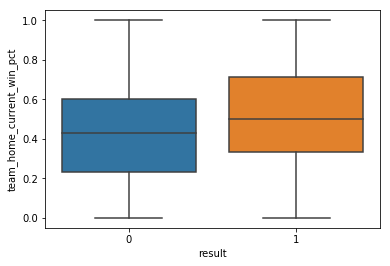

In [121]:
sns.boxplot(x="result", y="team_home_current_win_pct", data=df)

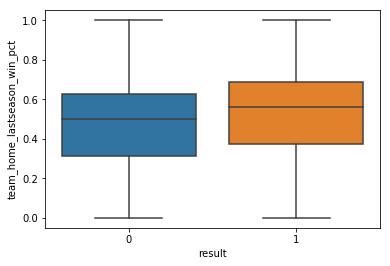

In [122]:
sns.boxplot(x="result", y="team_home_lastseason_win_pct", data=df)

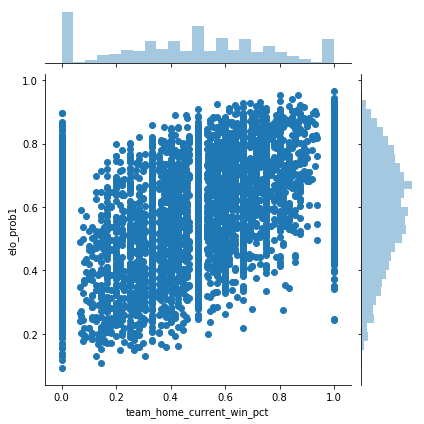

In [113]:
# Slight positive correlation between team with higher current record and elo prob
sns.jointplot('team_home_current_win_pct', 'elo_prob1', data=df)

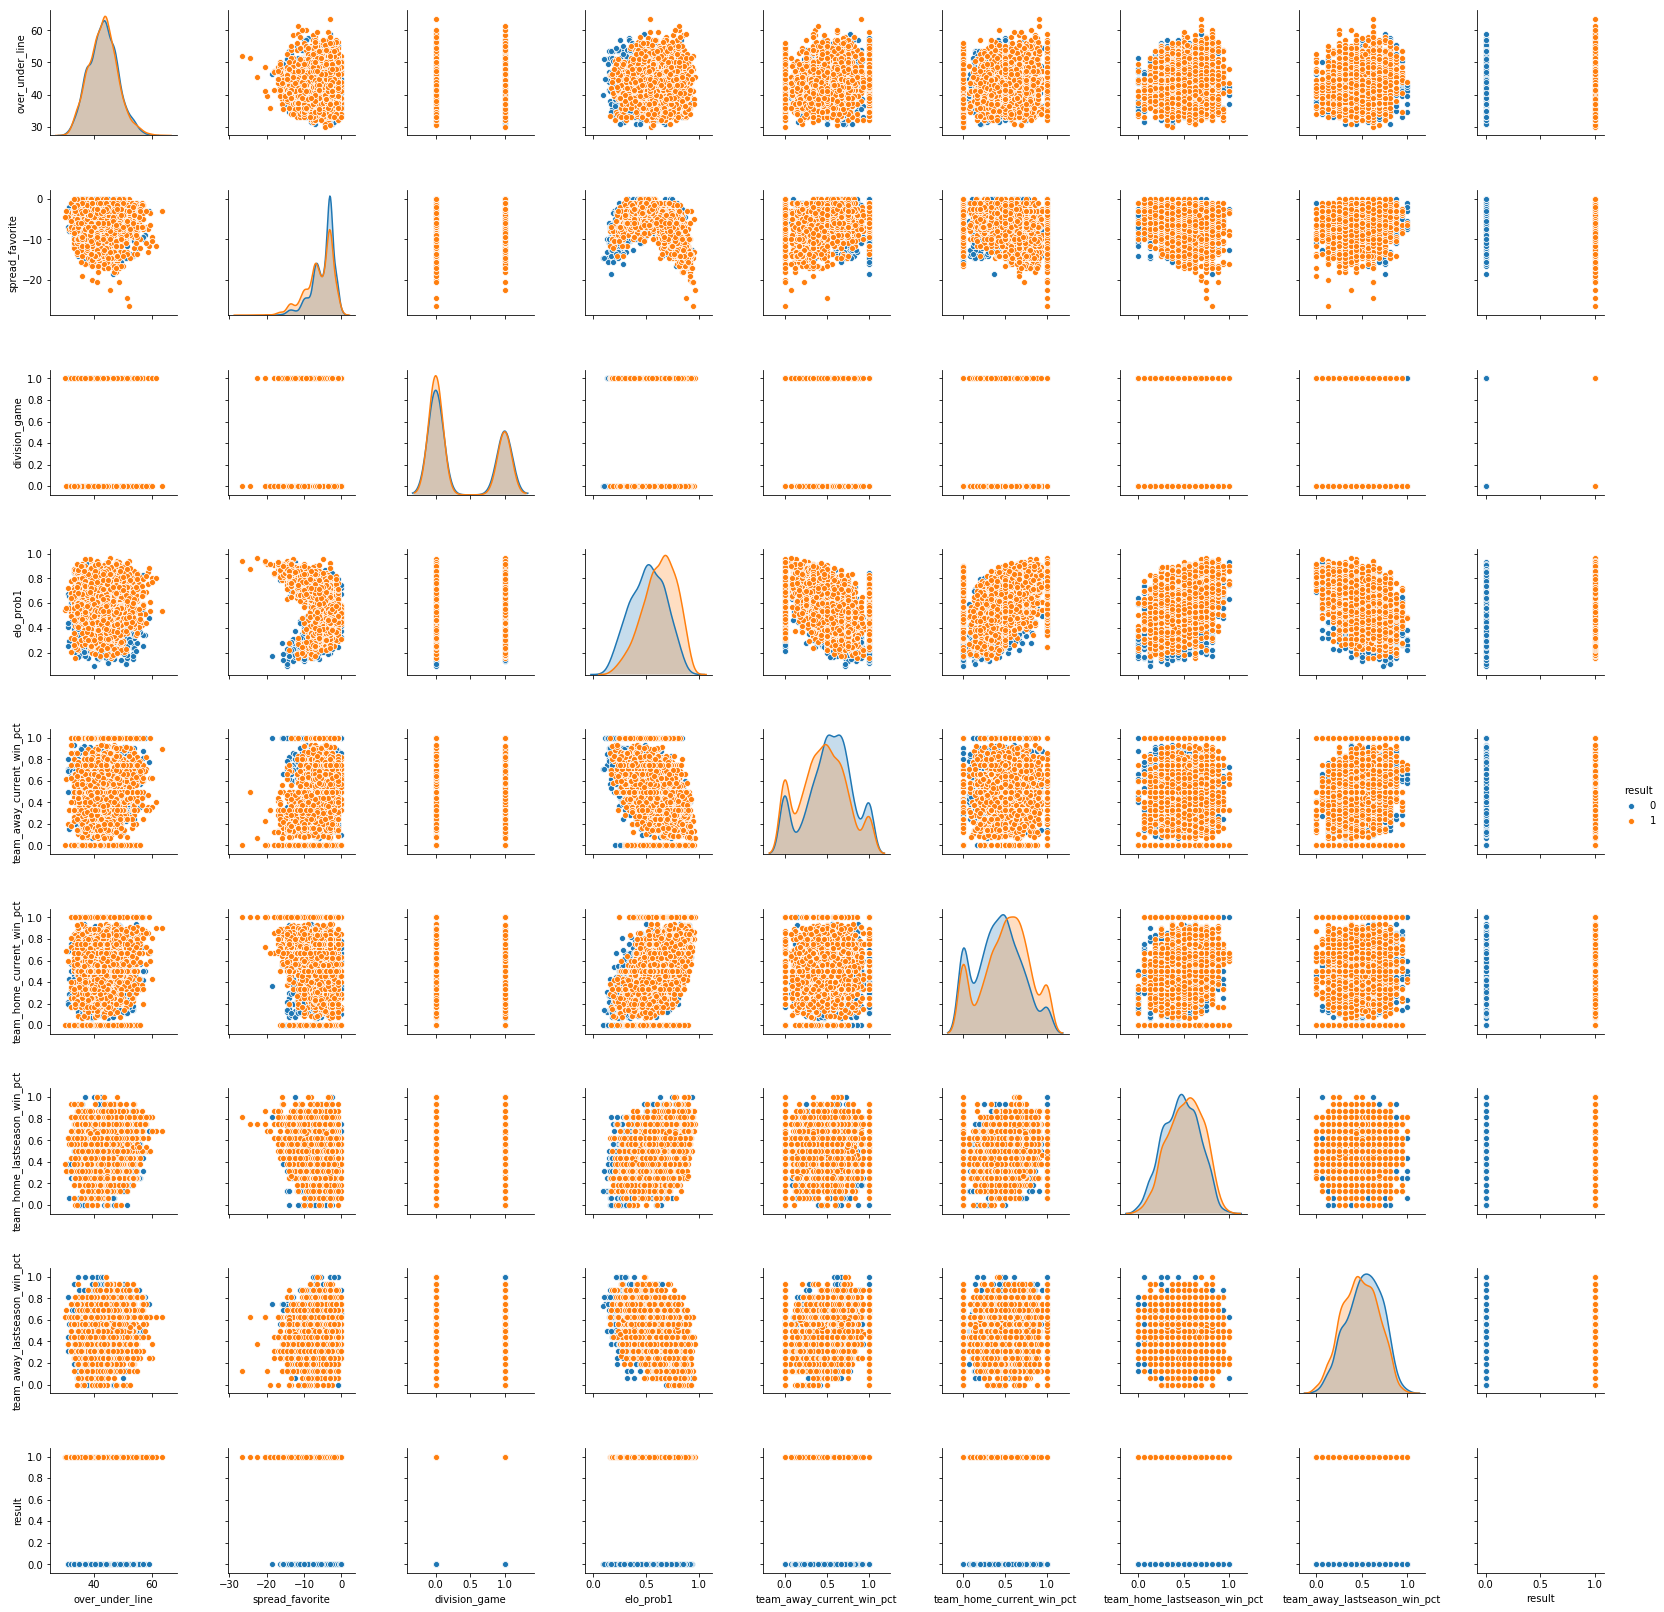

In [118]:
sns.pairplot(df[[ 'over_under_line', 'spread_favorite', 'division_game', 'elo_prob1',
                 'team_away_current_win_pct', 'team_home_current_win_pct', 'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct', 'result']], hue='result', height=2.5);

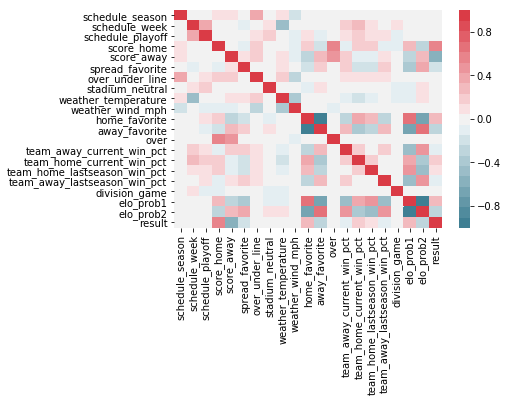

In [95]:
ax2 = sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap=sns.diverging_palette(h_neg=220,h_pos=10,n=21))

# Feature and Model Testing 
## Predict probability the the Home team will win p(y=1; x)

In [41]:
df.columns.values

array(['schedule_date', 'schedule_season', 'schedule_week',
       'schedule_playoff', 'team_home', 'score_home', 'score_away',
       'team_away', 'team_favorite_id', 'spread_favorite',
       'over_under_line', 'stadium', 'stadium_neutral',
       'weather_temperature', 'weather_wind_mph', 'weather_humidity',
       'weather_detail', 'home_favorite', 'away_favorite', 'over',
       'team_away_current_win_pct', 'team_home_current_win_pct',
       'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct',
       'team_home_division', 'team_away_division', 'division_game',
       'elo_prob1', 'elo_prob2', 'result'], dtype=object)

In [42]:
df.over_under_line.describe()

count    4783.000000
mean       43.237194
std         4.908705
min        30.000000
25%        40.000000
50%        43.500000
75%        46.500000
max        63.500000
Name: over_under_line, dtype: float64

In [43]:
# initial features possible for model
# X = df[['schedule_season', 'schedule_week', 'over_under_line', 'spread_favorite', 'weather_temperature', 'weather_wind_mph',
#         'home_favorite', 'hm_avg_pts_diff','aw_avg_pts_diff', 'elo1', 'elo2', 'elo_prob1']]
X = df[['schedule_week', 'over_under_line', 'spread_favorite', 'division_game', 'elo_prob1', 'elo_prob2', 'home_favorite',
        'team_away_current_win_pct', 'team_home_current_win_pct', 'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct']]

y = df['result']

In [44]:
X.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
schedule_week,4783.0,9.486933,5.254918,1.000000,5.000000,10.000000,14.000000,21.000000
over_under_line,4783.0,43.237194,4.908705,30.000000,40.000000,43.500000,46.500000,63.500000
spread_favorite,4783.0,-5.374242,3.387991,-26.500000,-7.000000,-4.500000,-3.000000,0.000000
division_game,4783.0,0.360025,0.480058,0.000000,0.000000,0.000000,1.000000,1.000000
elo_prob1,4783.0,0.582349,0.168648,0.092782,0.465489,0.591249,0.709157,0.964578
elo_prob2,4783.0,0.417651,0.168648,0.035422,0.290843,0.408751,0.534511,0.907218
home_favorite,4783.0,0.664227,0.472309,0.000000,0.000000,1.000000,1.000000,1.000000
team_away_current_win_pct,4783.0,0.485643,0.282846,0.000000,0.307692,0.500000,0.666667,1.000000
team_home_current_win_pct,4783.0,0.470203,0.285013,0.000000,0.285714,0.500000,0.666667,1.000000
team_home_lastseason_win_pct,4783.0,0.503174,0.194765,0.000000,0.375000,0.500000,0.625000,1.000000


In [133]:
# required machine learning packages
from sklearn import model_selection
from sklearn.feature_selection import RFE
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV as CCV
from sklearn.svm import LinearSVC

from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import xgboost as xgb

In [101]:
# training and testing data
train = df.copy()
test = df.copy()
train = train.loc[train['schedule_season'] < 2016]
test = test.loc[test['schedule_season'] > 2015]
X_train = train[['schedule_week', 'over_under_line', 'spread_favorite', 'division_game', 'elo_prob1', 'home_favorite',
                 'team_away_current_win_pct', 'team_home_current_win_pct', 'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct']]
y_train = train['result']

X_test = test[['schedule_week', 'over_under_line', 'spread_favorite', 'division_game', 'elo_prob1', 'home_favorite',
               'team_away_current_win_pct', 'team_home_current_win_pct', 'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct']]
y_test = test['result']

In [ ]:
# prepare models
models = []

models.append(('LRG', LogisticRegression(solver='liblinear')))
models.append(('KNB', KNeighborsClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('XGB', xgb.XGBClassifier(random_state=0)))
models.append(('RFC', RandomForestClassifier(random_state=0, n_estimators=100)))
models.append(('DTC', DecisionTreeClassifier(random_state=0, criterion='entropy', max_depth=5)))
models.append(('SVC', LinearSVC(random_state=0)))
models.append(('VOTE', VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')))
models.append(('CCV', CCV(vote, method='isotonic', cv=3)))
models.append(('MLP', MLPClassifier()))
models.append(('ADA', AdaBoostClassifier(random_state=0)))


# evaluate each model by average and standard deviations of roc auc 
results = []
names = []

for name, m in models:
    kfold = model_selection.KFold(n_splits=5, random_state=0)
    cv_results = model_selection.cross_val_score(m, X_train, y_train, cv=kfold, scoring = 'roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LRG: 0.692796 (0.013060)
KNB: 0.575542 (0.010872)
GNB: 0.690319 (0.016790)
XGB: 0.688443 (0.012521)
RFC: 0.667276 (0.013321)
DTC: 0.690525 (0.016271)


/Users/ukritw/miniconda3/envs/machine_learning/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ukritw/miniconda3/envs/machine_learning/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ukritw/miniconda3/envs/machine_learning/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ukritw/miniconda3/envs/machine_learning/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/ukritw/miniconda3/envs/machine_learning/lib/pytho

SVC: 0.680355 (0.015469)
VOTE: 0.698681 (0.013539)


In [102]:
# calibrate probabilities and fit model to training data
boost = xgb.XGBClassifier()
dtc = DecisionTreeClassifier(max_depth=5, criterion='entropy')
lrg = LogisticRegression(solver='liblinear')
vote = VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')

# model = CCV(vote, method='isotonic', cv=3)
# model.fit(X_train, y_train)

In [127]:
# model = lrg.fit(X_train, y_train)
# model = dtc.fit(X_train, y_train)
model = boost.fit(X_train, y_train)

In [128]:
# predict probabilities
predicted = model.predict_proba(X_test)[:,1]

In [105]:
model.score(X_test, y_test)

0.66202531645569618

In [106]:
predictions = model.predict(X_test)

In [107]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[174 155]
 [112 349]]


In [70]:
model.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)>

In [71]:
# ['schedule_week', 'over_under_line', 'spread_favorite', 
#  'division_game', 'elo_prob1', 'elo_prob2', 
#  'home_favorite', 'team_away_current_win_pct', 'team_home_current_win_pct', 
#  'team_home_lastseason_win_pct', 'team_away_lastseason_win_pct']
model.coef_

array([[-0.00971576, -0.00351463, -0.05007655, -0.1400911 ,  1.27278913,
        -1.50386269,  0.60938442, -0.03594842,  0.06662771, -0.28989452,
         0.37220857]])

In [119]:
# ROC AUC Score higher is better while Brier Score the lower the better
print("Metrics" + "\t\t" + "My Model" + "\t" + "Elo Results")
print("ROC AUC Score: " +  "\t" + "{:.4f}".format(roc_auc_score(y_test, predicted)) + "\t\t" + "{:.4f}".format(roc_auc_score(test.result, test.elo_prob1)))
print("Brier Score: " + "\t" + "{:.4f}".format(brier_score_loss(y_test, predicted)) + "\t\t" + "{:.4f}".format(brier_score_loss(test.result, test.elo_prob1)))

Metrics		My Model	Elo Results
ROC AUC Score: 	0.6966		0.6818
Brier Score: 	0.2161		0.2189


# Debugging Training Process

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

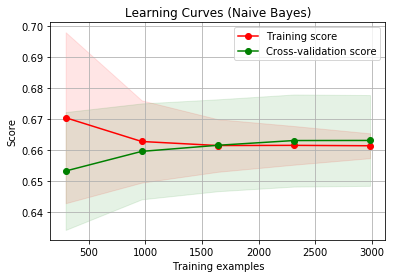

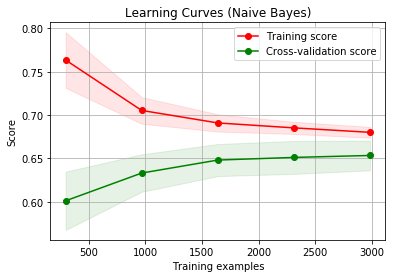

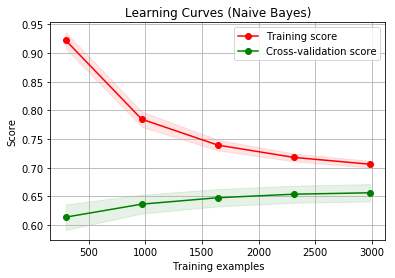

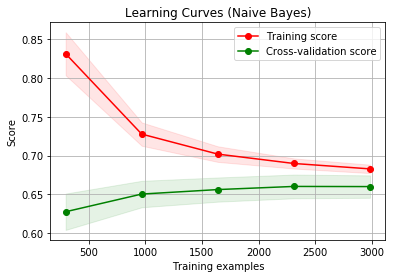

In [56]:
# digits = load_digits()
# X, y = digits.data, digits.target


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

lrg = LogisticRegression(solver='liblinear')
plot_learning_curve(lrg, title, X_train, y_train, cv=cv, n_jobs=4)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

dtc = DecisionTreeClassifier(max_depth=5, criterion='entropy')
plot_learning_curve(dtc, title, X_train, y_train, cv=cv, n_jobs=4)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

boost = xgb.XGBClassifier()
plot_learning_curve(boost, title, X_train, y_train, cv=cv, n_jobs=4)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

vote = VotingClassifier(estimators=[('boost', boost), ('dtc', dtc), ('lrg', lrg)], voting='soft')
plot_learning_curve(vote, title, X_train, y_train, cv=cv, n_jobs=4)

plt.show()

## Bets simulation 
Bet if more than 0.60 prob

In [72]:
test.loc[:,'hm_prob'] = predicted
test = test[['schedule_season', 'schedule_week', 'team_home', 'team_away', 'elo_prob1', 'hm_prob', 'result']]

In [81]:
# calulate bets won (only make a bet when probability is greater than / equal to 60% or less than / equal to 40%)
test['my_bet_won'] = (((test.hm_prob >= 0.60) & (test.result == 1)) | ((test.hm_prob <= 0.40) & (test.result == 0))).astype(int)
test['elo_bet_won'] = (((test.elo_prob1 >= 0.60) & (test.result == 1)) | ((test.elo_prob1 <= 0.40) & (test.result == 0))).astype(int)

# calulate bets lost (only make a bet when probability is greater than / equal to 60% or less than / equal to 40%)
test['my_bet_lost'] = (((test.hm_prob >= 0.60) & (test.result == 0)) | ((test.hm_prob <= 0.40) & (test.result == 1))).astype(int)
test['elo_bet_lost'] = (((test.elo_prob1 >= 0.60) & (test.result == 0)) | ((test.elo_prob1 <= 0.40) & (test.result == 1))).astype(int)

In [82]:
# printing some quick overall results for my model
print("My Model Win Percentage: " + "{:.4f}".format(test.my_bet_won.sum() / (test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Total Number of Bets Won: " + str(test.my_bet_won.sum()))
print("Total Number of Bets Made: " + str((test.my_bet_lost.sum() + test.my_bet_won.sum())))
print("Possible Games: " + str(len(test)))

My Model Win Percentage: 0.6909
Total Number of Bets Won: 409
Total Number of Bets Made: 592
Possible Games: 790


In [83]:
# printing some quick overall results for fivethirtyeight's ELO model
print("ELO Model Win Percentage: " + "{:.4f}".format(test.elo_bet_won.sum()/(test.elo_bet_lost.sum() + test.elo_bet_won.sum())))
print("Total Number of Bets Won: " + str(test.elo_bet_won.sum()))
print("Total Number of Bets Made: " + str((test.elo_bet_lost.sum() + test.elo_bet_won.sum())))
print("Possible Games: " + str(len(test)))

ELO Model Win Percentage: 0.6896
Total Number of Bets Won: 351
Total Number of Bets Made: 509
Possible Games: 790


In [76]:
# creating week by week results
results_df = test.groupby(['schedule_season', 'schedule_week']).agg({'team_home' : 'count', 'my_bet_won' : 'sum', 
'elo_bet_won' : 'sum', 'my_bet_lost' : 'sum', 'elo_bet_lost' : 'sum'}).reset_index().rename(columns=
                                                                                            {'team_home' : 'total_games'})

# counting total bets for my model and the ELO model (prob >= 60% or prob <= 40%)
results_df['total_bets'] = results_df.my_bet_won + results_df.my_bet_lost
results_df['elo_total_bets'] = results_df.elo_bet_won + results_df.elo_bet_lost

# creating accuracy columns based on bets made not on total games
results_df['bet_accuracy'] = round((results_df.my_bet_won / results_df.total_bets) * 100, 2)
results_df['elo_bet_accuracy'] = round((results_df.elo_bet_won / results_df.elo_total_bets) * 100, 2)
results_df = results_df[['schedule_season', 'schedule_week', 'bet_accuracy', 'elo_bet_accuracy',
                         'total_bets', 'elo_total_bets', 'total_games']]

In [77]:
results_df

,schedule_season,schedule_week,bet_accuracy,elo_bet_accuracy,total_bets,elo_total_bets,total_games
0,2016,1,72.73,66.67,11,9,16
1,2016,2,72.73,63.64,11,11,16
2,2016,3,66.67,77.78,12,9,16
3,2016,4,50.00,50.00,14,10,15
4,2016,5,58.33,60.00,12,10,14
5,2016,6,57.14,60.00,14,10,15
6,2016,7,57.14,66.67,7,6,15
7,2016,8,71.43,60.00,7,5,13
8,2016,9,66.67,57.14,9,7,13
9,2016,10,40.00,42.86,5,7,14


# Sanity check

In [85]:
pd.set_option('display.max_columns', 500)
df.loc[(df.schedule_season == 2018) & (df.schedule_week == 17)]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail,home_favorite,away_favorite,over,team_away_current_win_pct,team_home_current_win_pct,team_home_lastseason_win_pct,team_away_lastseason_win_pct,team_home_division,team_away_division,division_game,elo_prob1,elo_prob2,result
54,2018-12-30,2018,17,0,MIN,10.0,24.0,CHI,MIN,-6.0,40.5,U.S. Bank Stadium,0,72.0,0.0,NaN,DOME,1,0,0.0,0.750000,0.533333,0.8125,0.3125,NFC North,NFC North,1,0.560701,0.439299,0
443,2018-12-30,2018,17,0,HOU,20.0,3.0,JAX,HOU,-7.0,39.5,NRG Stadium,0,72.0,0.0,NaN,DOME,1,0,0.0,0.312500,0.687500,0.2500,0.6250,AFC South,AFC South,1,0.708548,0.291452,1
461,2018-12-30,2018,17,0,BAL,26.0,24.0,CLE,BAL,-7.0,41.0,M&T Bank Stadium,0,48.0,2.0,NaN,NaN,1,0,1.0,0.466667,0.625000,0.5625,0.0000,AFC North,AFC North,1,0.811471,0.188529,1
669,2018-12-30,2018,17,0,TEN,17.0,33.0,IND,IND,-5.5,42.5,Nissan Stadium,0,53.0,4.0,NaN,NaN,0,1,1.0,0.625000,0.562500,0.5625,0.2500,AFC South,AFC South,1,0.621961,0.378039,0
1033,2018-12-30,2018,17,0,PIT,16.0,13.0,CIN,PIT,-14.0,45.0,Heinz Field,0,42.0,9.0,NaN,NaN,1,0,0.0,0.375000,0.600000,0.8125,0.4375,AFC North,AFC North,1,0.827144,0.172856,1
2070,2018-12-30,2018,17,0,LAR,48.0,32.0,SF,LAR,-10.5,49.5,Los Angeles Memorial Coliseum,0,65.0,3.0,NaN,NaN,1,0,1.0,0.250000,0.812500,0.6875,0.3750,NFC West,NFC West,1,0.851315,0.148685,1
2344,2018-12-30,2018,17,0,NYG,35.0,36.0,DAL,NYG,-7.5,38.5,MetLife Stadium,0,37.0,2.0,NaN,NaN,1,0,1.0,0.625000,0.312500,0.1875,0.5625,NFC East,NFC East,1,0.380205,0.619795,0
2561,2018-12-30,2018,17,0,BUF,42.0,17.0,MIA,BUF,-5.5,39.5,New Era Field,0,33.0,9.0,NaN,NaN,1,0,1.0,0.437500,0.375000,0.5625,0.3750,AFC East,AFC East,1,0.589478,0.410522,1
2800,2018-12-30,2018,17,0,NE,38.0,3.0,NYJ,NE,-14.5,46.5,Gillette Stadium,0,33.0,2.0,NaN,NaN,1,0,0.0,0.250000,0.687500,0.8125,0.3125,AFC East,AFC East,1,0.892106,0.107894,1
3175,2018-12-30,2018,17,0,KC,35.0,3.0,OAK,KC,-14.5,52.5,Arrowhead Stadium,0,45.0,15.0,NaN,NaN,1,0,0.0,0.250000,0.750000,0.6250,0.3750,AFC West,AFC West,1,0.883113,0.116887,1
